In [218]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

np.random.seed(13)

In [219]:
data = pd.read_csv("train.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [220]:
data.drop(['PassengerId', 'Name', 'Cabin', 'Embarked', 'Ticket'], axis=1, inplace=True)
data["Sex"] = data["Sex"].apply(lambda x: 1 if x == "male" else 0)

grouped_age = data.groupby(['Pclass', 'Sex'])['Age'].median()


def fill_age(x):
    if np.isnan(x['Age']):
        return grouped_age[x['Pclass'], x['Sex']]
    return x['Age']


data['Age'] = data.apply(fill_age, axis=1)

In [221]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
dtypes: float64(2), int64(5)
memory usage: 48.9 KB


array([[<Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>,
        <Axes: title={'center': 'Sex'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Fare'}>, <Axes: >, <Axes: >]],
      dtype=object)

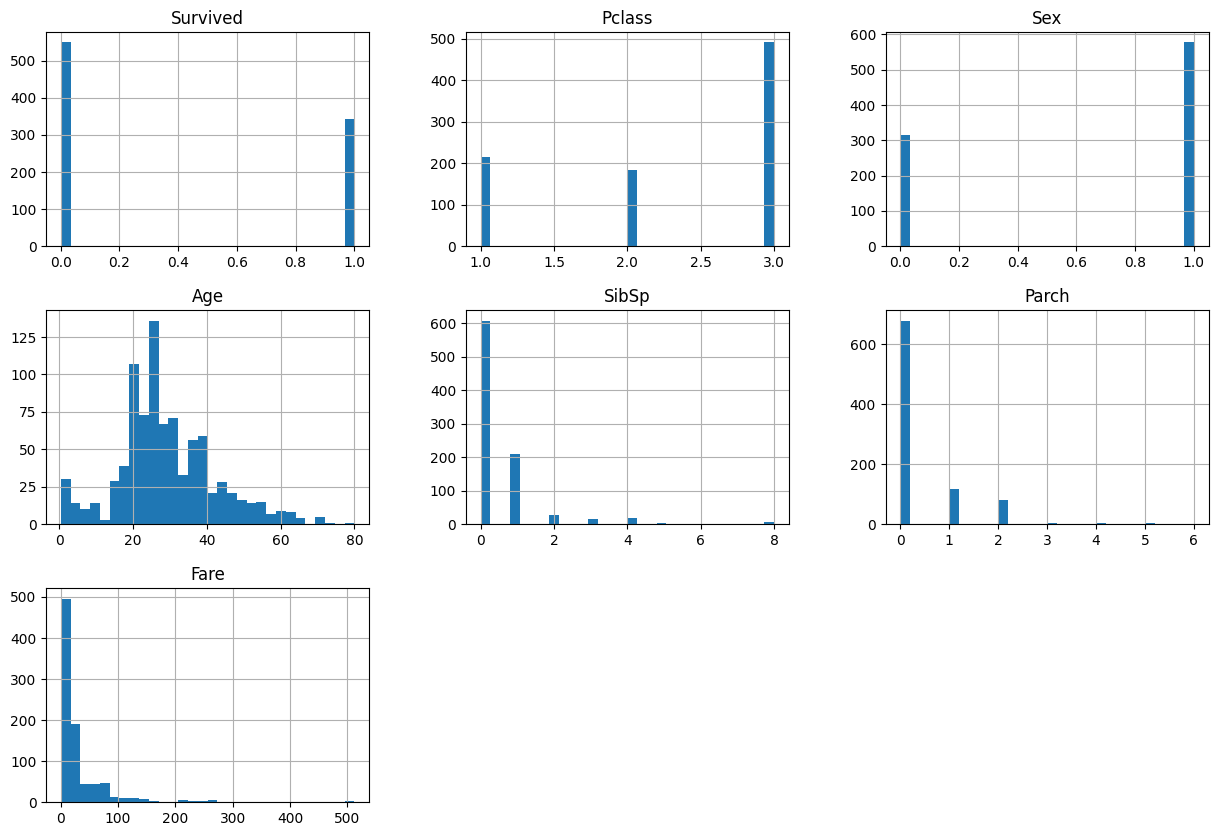

In [222]:
data.hist(bins=30, figsize=(15, 10))

In [223]:
from sklearn.preprocessing import StandardScaler

x = data.drop('Survived', axis=1).to_numpy()
y = data['Survived'].to_numpy()


def normalize(x):
    scaler = StandardScaler()
    scaler.fit(x)
    return scaler.transform(x)


x = normalize(x)
x.mean(), x.std()

(1.4454082026545247e-17, 1.0)

<h2>Logistic regression</h2>
Вычисление предсказания логистической регрессией для объекта $x_i \in \mathbb{R}^n$ :

* $z = w^T x_i + b, \quad w \in \mathbb{R}^n, b \in \mathbb{R}$
* $a = \sigma (z)$

Сигмоида

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

![alt text](https://upload.wikimedia.org/wikipedia/commons/a/ac/Logistic-curve.png)

Логистическая фунция потерь:

$$L_i(a) = -y_i \cdot log(a) - (1 - y_i) \cdot log(1 - a)$$

Производные функции по параметрам:

$$\frac{\partial L_i}{\partial w} = \frac{\partial L_i}{\partial a} \cdot \frac{\partial a}{\partial z} 
\cdot \frac{\partial z}{\partial w} = \frac {a - y_i} {a \cdot (1-a)} \cdot a \cdot (1-a) \cdot x_i = (a-y_i) \cdot x_i $$

$$\frac{\partial L_i}{\partial b} = \frac{\partial L_i}{\partial a} \cdot \frac{\partial a}{\partial z} 
\cdot \frac{\partial z}{\partial b} = \frac {a - y_i} {a \cdot (1-a)} \cdot a \cdot (1-a) \cdot 1 = a-y_i $$

Используются для минимизации функции потерь $L$ с помощью градиентного спуска.


In [224]:
def log_loss(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred), axis=0) / len(y_true)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

<h2>Train-Test split</h2>

In [225]:
from sklearn.model_selection import train_test_split

sample_amount = 0.3
random_state = 336771

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=sample_amount, random_state=random_state,
                                                    stratify=y)


In [226]:
X_train.shape, X_test.shape

((623, 6), (268, 6))

In [227]:
m, n = X_train.shape
print(f'Число объектов в обучающей выборке: {m}\nРазмерность объекта: {n}')

Число объектов в обучающей выборке: 623
Размерность объекта: 6


In [228]:
class LogisticRegression:

    def __init__(self):
        self.w = np.random.randn(n, 1) * 0.001
        self.b = np.random.randn() * 0.001
        self.report_every = 40

    def train(self, X, y, learning_rate=0.005, epochs=40):
        self.losses_train = []
        self.losses_test = []

        for epoch in range(epochs):
            dw = np.zeros((n, 1))
            db = 0

            for i in range(len(X)):
                # forward propagation
                z = X[i].reshape(1, n).dot(self.w) + self.b
                a = sigmoid(z)[0][0]

                # gradient calculation
                dw += (a - y[i]) * X[i].reshape(n, 1)
                db += (a - y[i])

            dw /= len(X)
            db /= len(X)

            # gradient step
            self.w = self.w - learning_rate * dw
            self.b = self.b - learning_rate * db

            # save loss for plotting
            if epoch % self.report_every == 0:
                self.losses_train.append(log_loss(y, self.predict(X)))
                self.losses_test.append(log_loss(y_test, self.predict(X_test)))

    def train_vec(self, X, y, learning_rate=0.005, epochs=40):
        self.losses_train = []
        self.losses_test = []

        for epoch in range(epochs):
            Z = X.reshape(m, n).dot(self.w) + self.b
            A = sigmoid(Z)

            dw = np.sum(X.reshape(m, n) * (A.reshape(m, 1) - y.reshape(m, 1)), axis=0) / len(X)
            db = np.sum((A.reshape(m, 1) - y.reshape(m, 1)), axis=0) / len(X)

            # gradient step
            self.w = self.w - learning_rate * dw.reshape(n, 1)
            self.b = self.b - learning_rate * db

            # save loss for plotting
            if epoch % self.report_every == 0:
                self.losses_train.append(log_loss(y, self.predict(X)))
                self.losses_test.append(log_loss(y_test, self.predict(X_test)))

    def predict(self, X):
        return np.array([sigmoid(x.reshape(1, n).dot(self.w) + self.b)[0][0]
                         for x in X])

In [229]:
logreg = LogisticRegression()
logreg.train(X_train, y_train, learning_rate=0.05, epochs=500)

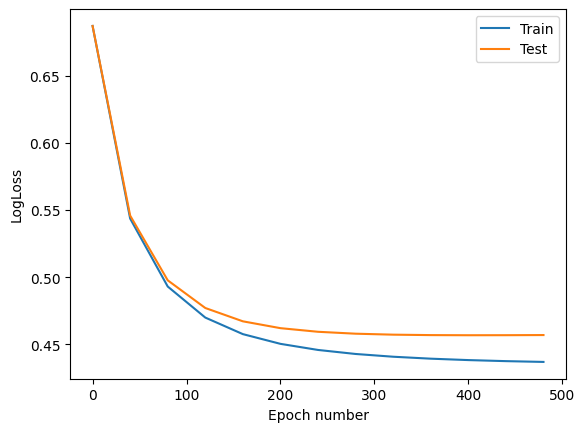

In [230]:
domain = np.arange(0, len(logreg.losses_train)) * logreg.report_every
plt.plot(domain, logreg.losses_train, label='Train')
plt.plot(domain, logreg.losses_test, label='Test')
plt.xlabel('Epoch number')
plt.ylabel('LogLoss')
plt.legend();

In [231]:
test_prediction = np.array(logreg.predict(X_test))
test_accuracy = np.sum((test_prediction > 0.5) == y_test) / len(test_prediction)
print(f'Точность на тестовой выборке: {round(test_accuracy * 100, 2)}%')

Точность на тестовой выборке: 78.36%


In [232]:
train_prediction = np.array(logreg.predict(X_train))
train_accuracy = np.sum((train_prediction > 0.5) == y_train) / len(train_prediction)
print(f'Точность на тренировочной выборке: {round(train_accuracy * 100, 2)}%')

Точность на тренировочной выборке: 81.54%


In [233]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Допустим, у вас есть предсказания модели на обучающем наборе
train_prediction = logreg.predict(X_train)

# Преобразуйте вероятности в бинарные метки (0 или 1) с использованием порога 0.5
train_prediction_binary = (train_prediction > 0.5).astype(int)

# Вычисление метрик
train_accuracy = accuracy_score(y_train, train_prediction_binary)
train_precision = precision_score(y_train, train_prediction_binary)
train_recall = recall_score(y_train, train_prediction_binary)
train_f1_score = f1_score(y_train, train_prediction_binary)

# Вывод результатов
print(f'Точность на обучающей выборке: {round(train_accuracy * 100, 2)}%')
print(f'Precision на обучающей выборке: {round(train_precision, 2)}')
print(f'Recall на обучающей выборке: {round(train_recall, 2)}')
print(f'F1-Score на обучающей выборке: {round(train_f1_score, 2)}')

Точность на обучающей выборке: 81.54%
Precision на обучающей выборке: 0.8
Recall на обучающей выборке: 0.69
F1-Score на обучающей выборке: 0.74
